In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.colors import to_rgba

import sys
sys.path.append("..")
from data_fitting import ODR_fitter
pd.set_option('display.max_rows', 10)

In [2]:
data_frame = pd.DataFrame()
with open("RedTopGreenBottom.txt", newline='') as csvfile:
    data_frame = pd.read_csv(csvfile, 
                             sep = '\t',
                             index_col=False,
                             header=0,
                             names=["x", "y"],
                             dtype={'x': 'int', 'y': 'float64'},
                             comment ='#')

# Add errors for x and y. Since ODR algorithm cannot allow x_error to be 0, we set it to 1
data_frame["x_err"] = 1
data_frame["y_err"] = np.sqrt(data_frame['y'])

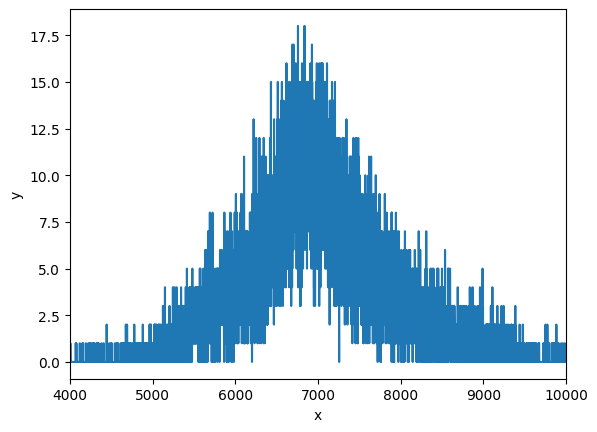

In [3]:
# Choose a range for the data fitting and get rid of zero y values
fit_range = [4000, 10000]
data_frame_range = data_frame.loc[(data_frame['x'] > fit_range[0]) & (data_frame['x'] < fit_range[1])]
data_frame_range = data_frame_range.loc[data_frame_range['y'] != 0]

ax = sns.lineplot(data=data_frame, x='x', y='y', drawstyle='steps');
ax.set_xlim(fit_range[0], fit_range[1]);

In [4]:
fitter = ODR_fitter(data_frame_range)
gaussian_fnt = lambda p,x : p[0] * np.exp(-((x-p[1]))**2*p[2])

# choose a reasonable peak position for the initial value
fit_result = fitter.fit(fnt=gaussian_fnt, inits = [1, 7000, 1])
fitter.print()

===============fitting result:=================
Beta: [6.77497345e+00 6.90961587e+03 7.52584300e-07]
Beta Std Error: [8.19678081e-02 7.93933308e+00 1.46981868e-08]
Beta Covariance: [[ 6.39110927e-03 -4.22533016e-03  7.74773748e-10]
 [-4.22533016e-03  5.99594505e+01  1.23780443e-09]
 [ 7.74773748e-10  1.23780443e-09  2.05502506e-16]]
Residual Variance: 1.0512606309388315
Inverse Condition #: 1.3388974336943314e-07
Reason(s) for Halting:
  Sum of squares convergence
p-value: 30.52%


/var/folders/gd/n_pgj6293ql93668yxpdjdr80000gn/T/ipykernel_67913/650882959.py:2: RuntimeWarning: overflow encountered in exp
  gaussian_fnt = lambda p,x : p[0] * np.exp(-((x-p[1]))**2*p[2])
/var/folders/gd/n_pgj6293ql93668yxpdjdr80000gn/T/ipykernel_67913/650882959.py:2: RuntimeWarning: overflow encountered in multiply
  gaussian_fnt = lambda p,x : p[0] * np.exp(-((x-p[1]))**2*p[2])


Peak position: 6909.615867915766


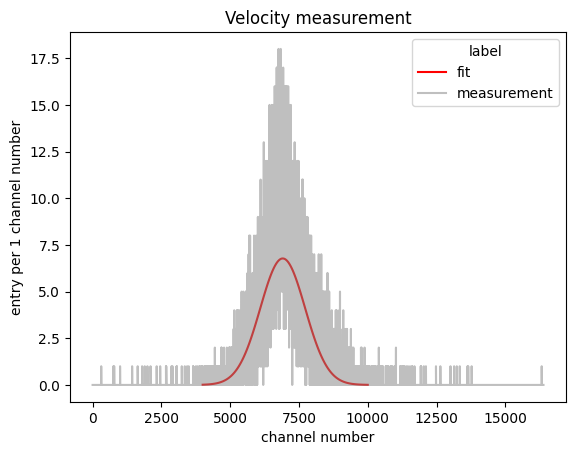

In [5]:
print(f"Peak position: {fit_result.beta[1]}")
fit_x = np.arange(fit_range[0], fit_range[1], step=1, dtype="int")
fit_y = gaussian_fnt(fit_result.beta, fit_x)

fit_dataframe = pd.DataFrame({"x": fit_x, "y": fit_y, "label": "fit"})
fit_dataframe = fit_dataframe.loc[fit_dataframe['y']>0]

measure_x = data_frame["x"].to_numpy()
measure_y = data_frame["y"].to_numpy()

meas_dataframe = pd.DataFrame({"x": measure_x, "y": measure_y, "label": "measurement"})

total_dataframe = pd.concat([fit_dataframe, meas_dataframe], ignore_index=True)

color_dict = {'fit': to_rgba('red', 1),
              'measurement': to_rgba('grey', 0.5)}
ax = sns.lineplot(data=total_dataframe, x='x', y='y', hue='label', palette=color_dict, drawstyle='steps');
ax.set_xlabel("channel number");
ax.set_ylabel("entry per 1 channel number");
ax.set_title("Velocity measurement");